In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs


In [2]:
stations = xarray.open_zarr('/scratch/snx3000/kschuurm/DATA/IEA_PVPS_europe.zarr')
stations

<xarray.Dataset>
Dimensions:       (station_name: 10, time: 3156062)
Coordinates:
    elevation     (station_name) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude      (station_name) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude     (station_name) float32 dask.array<chunksize=(1,), meta=np.ndarray>
  * station_name  (station_name) <U3 'CAB' 'CAR' 'CEN' ... 'TAB' 'TOR' 'VIS'
  * time          (time) datetime64[ns] 2015-01-01 ... 2020-12-31T17:01:00
Data variables:
    Azim          (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    DIF           (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    DNI           (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    Elev          (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    GHI           (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    GHIcalc       (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    Kc            (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>

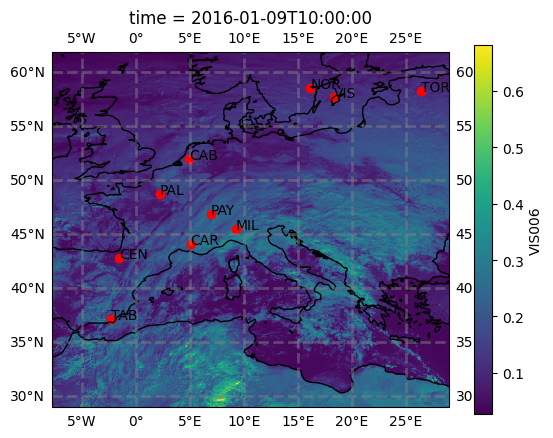

In [3]:
hrseviri = xarray.open_zarr('/scratch/snx3000/acarpent/EumetsatData/SEVIRI_WGS_2016-2022_RSS.zarr')

proj = ccrs.PlateCarree()

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=proj))

gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

axis.coastlines()

lat = stations.latitude.values
lon = stations.longitude.values
name = stations.station_name.values
axis.scatter(x=lon, y=lat, c='r')
for i, txt in enumerate(name):
    axis.annotate(txt, (lon[i], lat[i]))

hrseviri.VIS006.isel(time = 1000).plot.imshow(ax=axis, transform = proj)

In [ ]:

lat = stations.sel(station_name='CAB').latitude.data
lon = stations.sel(station_name='CAB').longitude.values
ilat = (np.abs(hrseviri.y - lat)).argmin().values
ilon = (np.abs(hrseviri.x - lon)).argmin().values

patch_size = 31
hpatch = int(np.floor(patch_size/2))

CAB_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch))
CAB_slice = CAB_slice.chunk({'time':10000})

for var in CAB_slice:
    CAB_slice[var].encoding['chunks'] = {'time':10000}

CAB_slice.to_zarr('/scratch/snx3000/kschuurm/DATA/HRSEVIRI_CAB.zarr', mode='w')


In [ ]:
CAB_slice = xarray.open_zarr('/scratch/snx3000/kschuurm/DATA/HRSEVIRI_CAB.zarr')

In [ ]:
stations.time

In [ ]:
CAB_slice = CAB_slice.dropna(dim='time')

In [ ]:
print('time slices:', len(CAB_slice.time)) #hrseviri should be full minute 
timenotnan = set(CAB_slice.time.values).intersection(set(stations.time.values))
timenotnan = np.sort(np.array(list(timenotnan)))
print('intersecting slices:', len(timenotnan))

In [ ]:
rolling = stations.sel(station_name='CAB').GHI.rolling(time=12,center=False).mean().dropna(dim='time')
# rolling average of 12 minutes (seviri takes 12 min to create an image
# time index is the right most index

from datetime import timedelta

rolling['time'] = rolling['time'] - np.timedelta64(12, 'm')

timenotnan = set(rolling.time.values).intersection(set(timenotnan))

In [ ]:
timenotnan = np.sort(np.array(list(timenotnan)))

In [ ]:
CAB_slice.VIS008.sel(time= timenotnan[0])

AttributeError: 'NoneType' object has no attribute 'shape'